In [1]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [3]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, 'channel_40x40x20_21tsteps_2923_satifying_cases.h5')
sat_t, logk = load_data(data_path, ['sat', 'logk'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)

sw_t shape is  (2923, 20, 40, 40, 21)
logk shape is  (2923, 20, 40, 40, 1)


In [4]:
print('sat_t max is ', np.max(sat_t))
print('sat_t min is ', np.min(sat_t))

sat_t max is  0.8000368591124947
sat_t min is  0.09996510886114912


In [5]:
sat_t[sat_t < 0.1] = 0.1
sat_t[sat_t > 0.8] = 0.8

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [6]:
depth = 10
nr = logk.shape[0]
train_nr = 2500
test_nr = 50

In [7]:
step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
train_x = np.concatenate([logk[:train_nr, ...], sat_t[:train_nr,:, :, :, [0]]], axis = -1)
train_y = sat_t[:train_nr, :, :, :, step_index]

test_x = np.concatenate([logk[nr-test_nr:, ...],  sat_t[nr-test_nr:, :, :, :, [0]]], axis = -1)
test_y = sat_t[nr-test_nr:,:, :, :, step_index]


# train_x = train_x.transpose(0,2,3,1)
train_y = train_y.transpose(0, 4, 1, 2, 3)
train_y = train_y[:, :, :, :, :, None]
# test_x = test_x.transpose(0,2,3,1)
test_y = test_y.transpose(0, 4, 1, 2, 3)
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2500, 20, 40, 40, 2)
train_y shape is  (2500, 10, 20, 40, 40, 1)
test_x shape is  (50, 20, 40, 40, 2)
test_y shape is  (50, 10, 20, 40, 40, 1)


<Figure size 432x288 with 0 Axes>

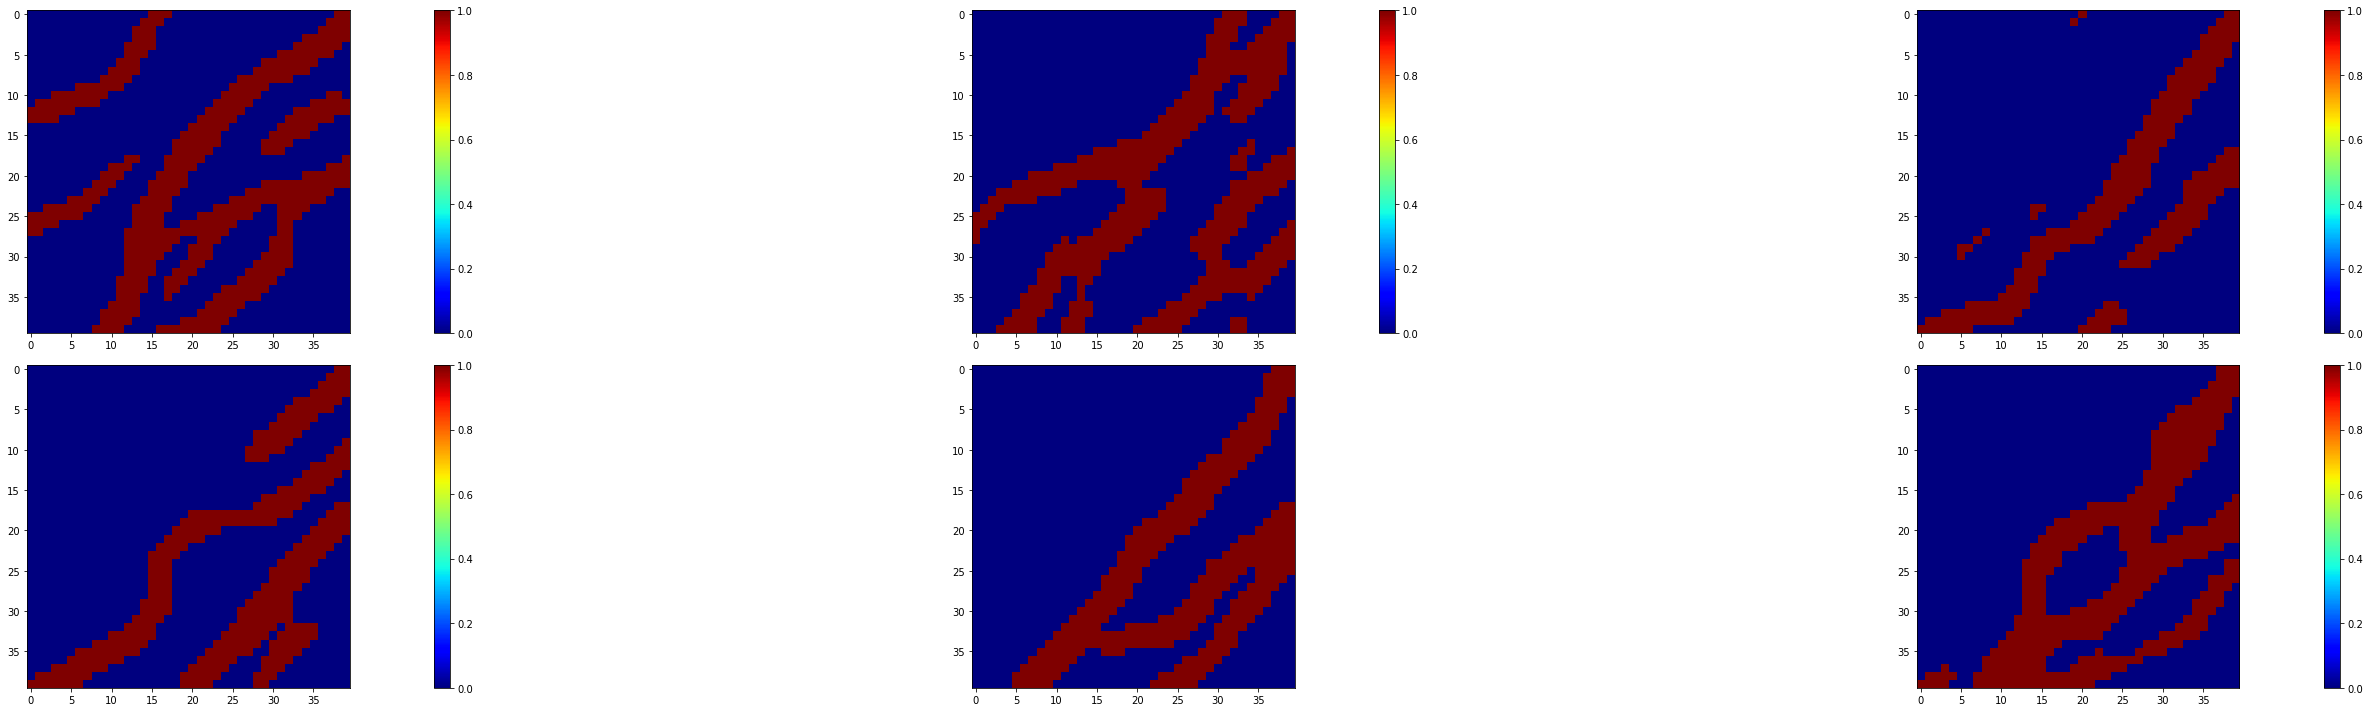

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20, 30, 40, 50]
plt.figure(figsize=(50,10))
for i, k in enumerate(ind_case):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_x[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
plt.show()

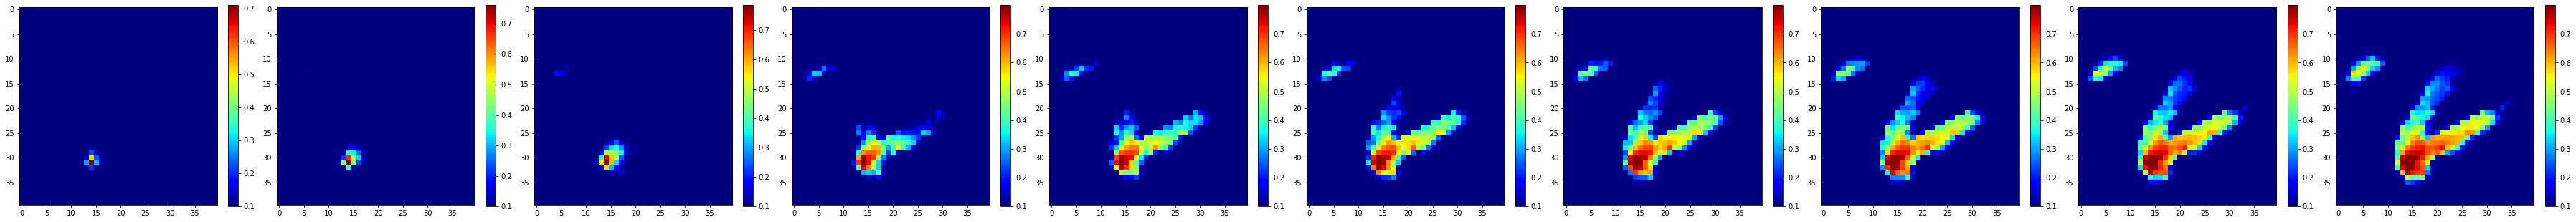

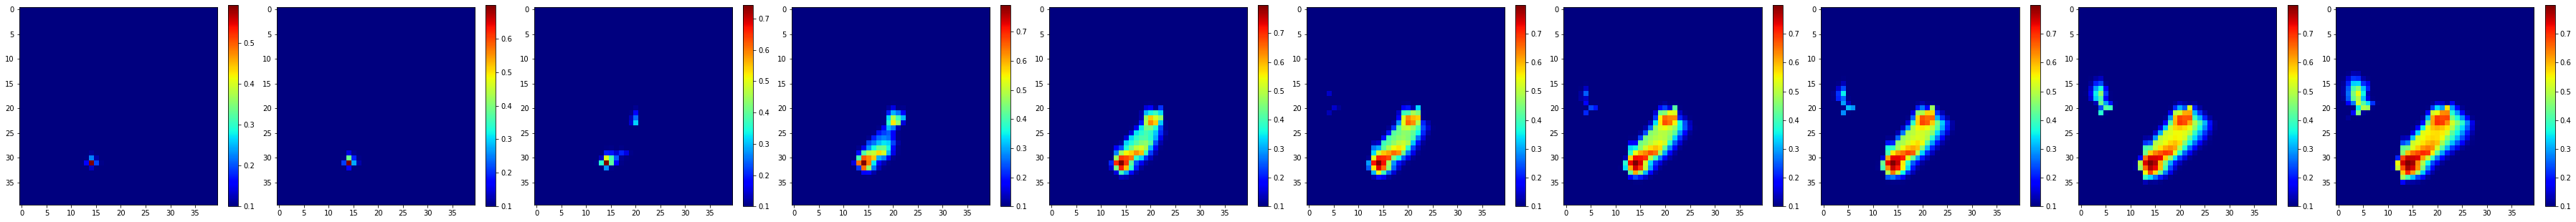

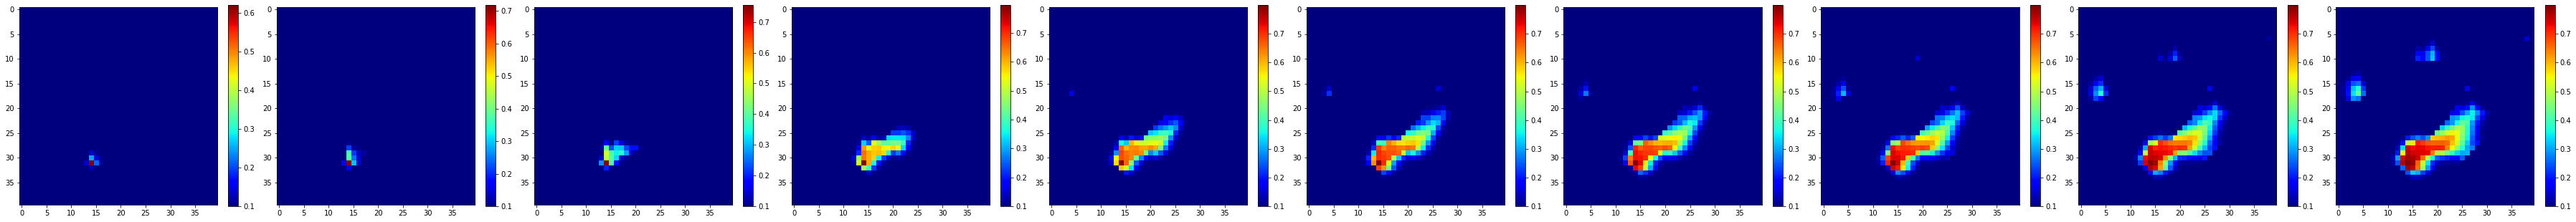

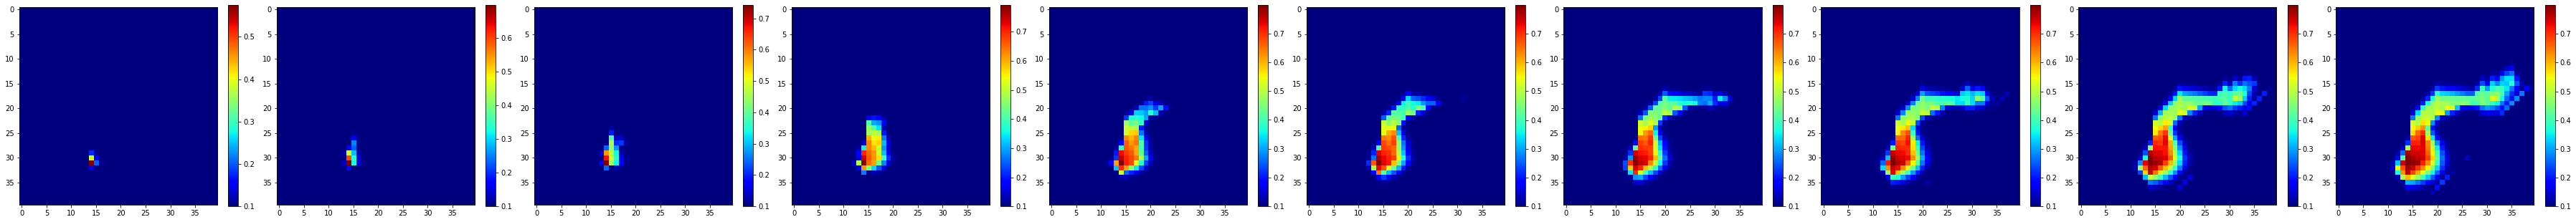

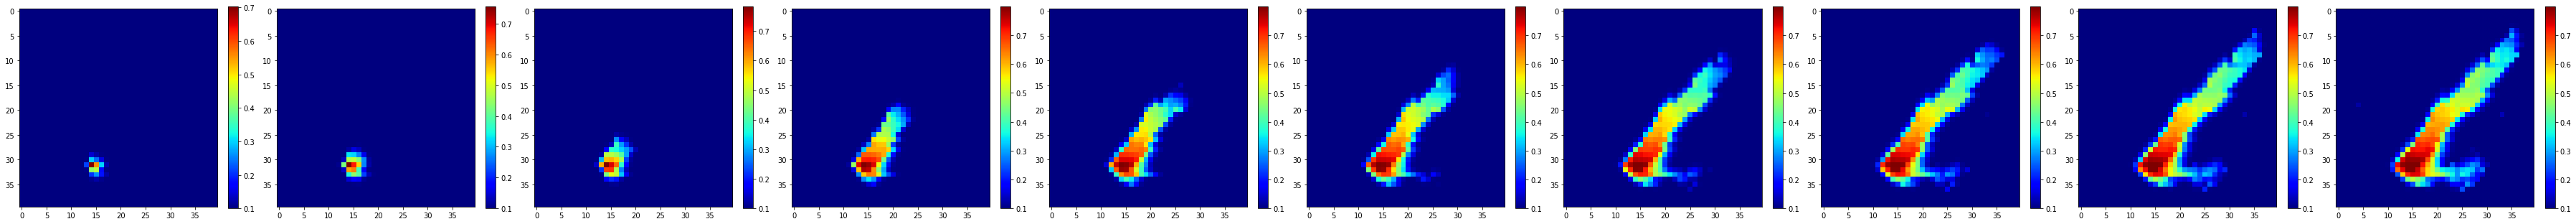

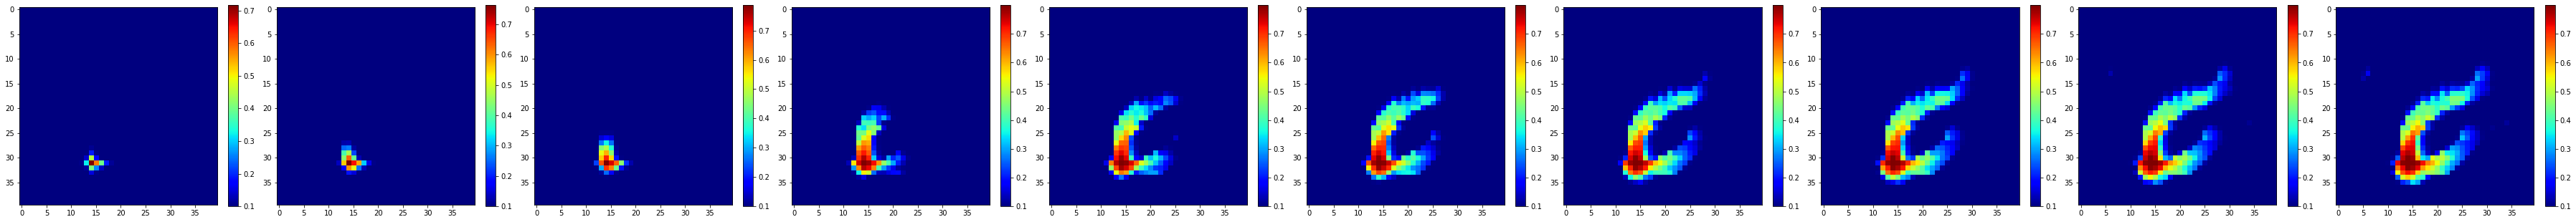

In [9]:
for i, k in enumerate(ind_case):
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(1, depth, i_tstep+1)
        plt.imshow(train_y[k, i_tstep, 0, :, :, 0])
        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

In [10]:
input_shape=(20, 40, 40, 2)
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary(line_length=150)





______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
image (InputLayer)                               (None, 20, 40, 40, 2)            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 10, 20, 20, 16)           880               image[0][0]                                       
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 10, 20, 20, 16)           64      

In [11]:
output_dir = 'saved_models/'
epochs = 500
train_nr = train_x.shape[0]
test_nr = 10
batch_size = 4
num_batch = int(train_nr/batch_size) 

In [12]:
def vae_loss(x, t_decoded):
    '''Total loss for the plain UAE'''
    return K.mean(reconstruction_loss(x, t_decoded))


def reconstruction_loss(x, t_decoded):
    '''Reconstruction loss for the plain UAE'''

    return K.sum((K.batch_flatten(x) - K.batch_flatten(t_decoded)) ** 2, axis=-1)

def hard_data_loss(x, t_decoded):
    '''Compute Hard Data at Well Loc'''
    # prod 0——based [11,12],[41, 43],[10, 42],[42, 10]
    
    well_loc_x = [14, 4, 37, 36, 9, 21]
    well_loc_y = [31, 19, 3, 21, 4, 3]
    result = 0.
    for i in range(len(well_loc_x)):
        result = result + K.sum((K.batch_flatten(x[:, :, :, well_loc_y[i], well_loc_x[i], :]) - K.batch_flatten(t_decoded[:, :, :, well_loc_y[i], well_loc_x[i], :]))**2, axis = -1)
    return K.mean(result)

def joint_loss(x, t_decoded):
    return vae_loss(x, t_decoded) + 500 * hard_data_loss(x, t_decoded)

In [13]:
def relative_error(x, t_decoded):
    return K.mean(K.abs(x - t_decoded) / x)

In [14]:
opt = Adam(lr=3e-4)
vae_model.compile(loss = joint_loss, optimizer = opt, metrics = [vae_loss, hard_data_loss, relative_error])

In [15]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lrScheduler = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 10, cooldown = 1, verbose = 1, min_lr = 1e-7)
filePath = 'saved_models/saved-model-10-steps-bs4-lr3e-4-saturation-hd-500-filter_16_32_32_64-mse-{epoch:03d}-{val_loss:.2f}.h5'
checkPoint = ModelCheckpoint(filePath, monitor = 'val_loss', verbose = 1, save_best_only = False, \
                             save_weights_only = True, mode = 'auto', period = 20)

callbacks_list = [lrScheduler, checkPoint]


In [ ]:
history = vae_model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, \
                        verbose = 1, validation_data = (test_x, test_y), callbacks = callbacks_list)